In [2]:
!pip install contractions
!pip install nltk
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install gensim
!pip install scikit-learn
!pip install wordcloud

In [3]:
import re

import contractions
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from numpy import *
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /Users/jerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jerry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Exploratory Data Analysis

### Cleaning positive and negative dataset

In [4]:
file_path = "data/Processed/pos.csv"
pos_unclean_df = pd.read_csv(file_path)
pos_unclean_df.drop(pos_unclean_df.columns[0], axis=1, inplace=True)
pos_unclean_df.head()

,FileName,Content,rating
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9
1,12390_8.txt,This movie looked like a classic in the cheesy...,8
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8


In [5]:
file_path = "data/Processed/neg.csv"
neg_unclean_df = pd.read_csv(file_path)
neg_unclean_df.drop(neg_unclean_df.columns[0], axis=1, inplace=True)
neg_unclean_df.head()

,FileName,Content,rating
0,3314_4.txt,Stan Laurel and Oliver Hardy are the most famo...,4
1,17112_1.txt,"I saw this movie a few years ago, and man I ne...",1
2,3008_1.txt,I watched this film few times and all i can sa...,1
3,17951_1.txt,From reading the back of the box my first thou...,1
4,9487_1.txt,This is a film of immense appeal to a relative...,1


In [6]:
pos_unclean_df['rating'].value_counts()
neg_unclean_df['rating'].value_counts()


rating
1    10122
4     5331
3     4961
2     4586
Name: count, dtype: int64

In [7]:
pos_unclean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  25000 non-null  object
 1   Content   25000 non-null  object
 2   rating    25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [8]:
neg_unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  25000 non-null  object
 1   Content   25000 non-null  object
 2   rating    25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [9]:
pos_unclean_df.describe()

,rating
count,25000.00000
mean,8.77064
std,1.15738
min,7.00000
25%,8.00000
50%,9.00000
75%,10.00000
max,10.00000


In [10]:
neg_unclean_df.describe()

,rating
count,25000.000000
mean,2.220040
std,1.186558
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [11]:
before_pos =  pos_unclean_df.shape[0]
pos_unclean_df.drop_duplicates(inplace=True)
after_pos = pos_unclean_df.shape[0]

before_neg =  neg_unclean_df.shape[0]
neg_unclean_df.drop_duplicates(inplace=True)
after_neg = pos_unclean_df.shape[0]

print("No. of rows removed from positive dataset:", before_pos - after_pos)
print("No. of rows removed from negative dataset:", before_neg - after_neg)


No. of rows removed from positive dataset: 0
No. of rows removed from negative dataset: 0


### Text pre-processing function bank

In [12]:
HTML_TAG_PATTERN = re.compile(r'<[^>]+>', re.IGNORECASE)

def remove_html(data):
    data = HTML_TAG_PATTERN.sub('', data)
    return data


def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data


def remove_emoji(data):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # additional symbols
                               u"\U000024C2-\U0001F251"  # additional symbols
                               u"\U0001F900-\U0001F9FF"  # supplementary symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # chess symbols, extended pictographs
                               u"\U0001FA70-\U0001FAFF"  # more extended pictographs
                               u"\U00002600-\U000026FF"  # miscellaneous symbols
                               u"\U00002700-\U000027BF"  # dingbats
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U000E0020-\U000E007F"  # Tag characters for emoji
                               "]+", flags=re.UNICODE)
    data = emoji_pattern.sub(r'', data)
    return data


def lowercase(text):
  word_list = str(text).split(' ')
  return ' '.join([word.lower() for word in word_list])


def remove_punctuation(text):
    punctuation_pattern = re.compile(r'[^\w\s]')
    clean_text = punctuation_pattern.sub('', text)
    return clean_text

### Cleaning the positive dataset

In [13]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_html(z))
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_url(z))
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_emoji(z))
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: lowercase(z))
#Remove contractions
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Cleaned_Content'].apply(contractions.fix)
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Cleaned_Content'].apply(lambda z: remove_punctuation(z))

In [14]:
pos_cleaned_df = pos_unclean_df
print("Uncleaned vs Cleaned version of positive dataset:")
pos_cleaned_df.head(20)

Uncleaned vs Cleaned version of positive dataset:


,FileName,Content,rating,Cleaned_Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9,i just watched return from lonesome dove and i...
1,12390_8.txt,This movie looked like a classic in the cheesy...,8,this movie looked like a classic in the cheesy...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8,jay chou plays an orphan raised in a kung fu s...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7,ooverall the movie was fairly good a good acti...
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8,this movie is fun to watch if you liked dave w...
5,10186_10.txt,I loved this movie. In fact I loved being an a...,10,i loved this movie in fact i loved being an ac...
6,22540_10.txt,Andaz Apna Apna is my favorite comedy movie of...,10,andaz apna apna is my favorite comedy movie of...
7,147_10.txt,"In the very first episode of Friends, which ai...",10,in the very first episode of friends which air...
8,3092_10.txt,"This, like Murder She Wrote, is one of those s...",10,this like murder she wrote is one of those sho...
9,15251_8.txt,Pretty good movie about a man and his wife who...,8,pretty good movie about a man and his wife who...


### Cleaning the negative dataset

In [15]:
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: remove_html(z))
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: remove_url(z))
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: remove_emoji(z))
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: lowercase(z))
#Remove contractions
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Cleaned_Content'].apply(contractions.fix)
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Cleaned_Content'].apply(lambda z: remove_punctuation(z))

In [16]:
neg_cleaned_df = neg_unclean_df
print("Uncleaned vs Cleaned version of negative dataset:")
neg_cleaned_df.head(20)

Uncleaned vs Cleaned version of negative dataset:


,FileName,Content,rating,Cleaned_Content
0,3314_4.txt,Stan Laurel and Oliver Hardy are the most famo...,4,stan laurel and oliver hardy are the most famo...
1,17112_1.txt,"I saw this movie a few years ago, and man I ne...",1,i saw this movie a few years ago and man i nev...
2,3008_1.txt,I watched this film few times and all i can sa...,1,i watched this film few times and all i can sa...
3,17951_1.txt,From reading the back of the box my first thou...,1,from reading the back of the box my first thou...
4,9487_1.txt,This is a film of immense appeal to a relative...,1,this is a film of immense appeal to a relative...
5,4518_1.txt,This is one of those movies you see in the vid...,1,this is one of those movies you see in the vid...
6,4604_4.txt,I admit the problem I have with the much-celeb...,4,i admit the problem i have with the muchcelebr...
7,5743_3.txt,This movie is not as good as all think. the ac...,3,this movie is not as good as all think the act...
8,9056_1.txt,"I just sat in the theater bored as hell, i wan...",1,i just sat in the theater bored as hell i want...
9,23687_3.txt,"This early film from director Bob Clark (""Pork...",3,this early film from director bob clark porkys...


### Further Deep Cleaning of data

Tokenization

In [17]:
tokenizer = TweetTokenizer()
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(tokenizer.tokenize)
neg_cleaned_df['Cleaned_Content'] = neg_cleaned_df['Cleaned_Content'].apply(tokenizer.tokenize)

Stopword Removal

In [18]:
#Just to check list of stopwords to ensure that the keep tokens isnt redunat
stop_words = set(stopwords.words('english'))
print(stop_words)

{'between', 'same', 'couldn', 'his', 'about', 'were', 'but', 'we', 'what', "hadn't", 'under', "you'd", 'he', 'off', 'your', 'won', 'those', 'through', 'to', 'which', 'against', "she's", 'you', 'did', 'theirs', 'she', "weren't", 'ours', 'himself', 'above', 'hadn', 'nor', 'their', 'after', 'are', 'd', 'shan', 'wasn', 'there', 'an', 'very', 'other', 'needn', 'and', 'up', 'o', "won't", 'a', 'doing', 'm', "shan't", "it's", 'below', 'its', 'into', 'down', 'until', 'this', 'all', "wasn't", 'these', "couldn't", 'who', 'own', 'myself', 'out', 'now', 'then', 'be', "don't", 'how', "wouldn't", 'while', 'any', 'yours', 'with', 'few', "aren't", 'do', 'have', "needn't", 'itself', 'before', 'herself', 'can', "you'll", 'some', "didn't", 'am', 'more', 'such', 'her', 'themselves', 'our', 'they', 'here', "doesn't", 'don', 'both', 'll', 'will', 'them', 'ain', "isn't", "mustn't", 'yourselves', "you've", 'from', 'ma', 'weren', 'y', 'each', 'isn', 'has', 'by', 'where', 'should', 'is', 'didn', 'during', 'just'

In [19]:
def filter_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    
    #Our n-grams analysis has shown that the <br> tag was not removed properly
    stop_words.add('br')  

    #Keep these words in the text as they could correlate to sentiment
    keep_in_tokens = [
        "isn't", "is",
        "wasn't", "was",
        "aren't", "are",
        "doesn't", "does",
        "couldn't", "could",
        "won't", "will",
        "shouldn't", "should",
        "didn't", "did",
        "haven't", "have"
    ]
    for word in keep_in_tokens:
        stop_words.discard(word)  
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

In [20]:
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(filter_tokens)
neg_cleaned_df['Cleaned_Content'] = neg_cleaned_df['Cleaned_Content'].apply(filter_tokens)

Lemmatization

In [21]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

In [22]:
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(lemmatize_tokens)
neg_cleaned_df['Cleaned_Content'] = neg_cleaned_df['Cleaned_Content'].apply(lemmatize_tokens)

In [23]:
print("Deep cleaned Positive Dataset")
pos_cleaned_df.head(10)

Deep cleaned Positive Dataset


,FileName,Content,rating,Cleaned_Content
0,20935_9.txt,"I just watched ""return from lonesome dove"" and...",9,watched return lonesome dove wa good have seen...
1,12390_8.txt,This movie looked like a classic in the cheesy...,8,movie looked like classic cheesy 80 slasher ge...
2,9820_8.txt,Jay Chou plays an orphan raised in a kung fu s...,8,jay chou play orphan raised kung fu school kic...
3,883_7.txt,"Ooverall, the movie was fairly good, a good ac...",7,ooverall movie wa fairly good good action plot...
4,9063_8.txt,"This movie is fun to watch. If you liked ""Dave...",8,movie is fun watch liked dave kevin klein will...
5,10186_10.txt,I loved this movie. In fact I loved being an a...,10,loved movie fact loved actress movie iwas feat...
6,22540_10.txt,Andaz Apna Apna is my favorite comedy movie of...,10,andaz apna apna is favorite comedy movie timeb...
7,147_10.txt,"In the very first episode of Friends, which ai...",10,first episode friend aired 22 sept 1994 one mo...
8,3092_10.txt,"This, like Murder She Wrote, is one of those s...",10,like murder wrote is one show stressful day sc...
9,15251_8.txt,Pretty good movie about a man and his wife who...,8,pretty good movie man wife get caught murder p...


In [24]:
print("Deep cleaned Negative Dataset")
neg_cleaned_df.head(10)

Deep cleaned Negative Dataset


,FileName,Content,rating,Cleaned_Content
0,3314_4.txt,Stan Laurel and Oliver Hardy are the most famo...,4,stan laurel oliver hardy are famous comedy duo...
1,17112_1.txt,"I saw this movie a few years ago, and man I ne...",1,saw movie year ago man never want golf mean ni...
2,3008_1.txt,I watched this film few times and all i can sa...,1,watched film time say is low budget rubbish do...
3,17951_1.txt,From reading the back of the box my first thou...,1,reading back box first thought wa is probably ...
4,9487_1.txt,This is a film of immense appeal to a relative...,1,is film immense appeal relatively welldefined ...
5,4518_1.txt,This is one of those movies you see in the vid...,1,is one movie see video store have get look hor...
6,4604_4.txt,I admit the problem I have with the much-celeb...,4,admit problem have muchcelebrated ealing film ...
7,5743_3.txt,This movie is not as good as all think. the ac...,3,movie is good think actor are lowlevel story i...
8,9056_1.txt,"I just sat in the theater bored as hell, i wan...",1,sat theater bored hell wanted leave halfway mo...
9,23687_3.txt,"This early film from director Bob Clark (""Pork...",3,early film director bob clark porkys black chr...


In [25]:
pos_df = pos_cleaned_df[['Cleaned_Content', 'rating']].copy()
pos_df.rename(columns = {'Cleaned_Content': 'Text', 'rating': "Sentiment"}, inplace=True)
pos_df.head()

,Text,Sentiment
0,watched return lonesome dove wa good have seen...,9
1,movie looked like classic cheesy 80 slasher ge...,8
2,jay chou play orphan raised kung fu school kic...,8
3,ooverall movie wa fairly good good action plot...,7
4,movie is fun watch liked dave kevin klein will...,8


In [26]:
neg_df = neg_cleaned_df[['Cleaned_Content', 'rating']].copy()
neg_df.rename(columns = {'Cleaned_Content': 'Text', 'rating': "Sentiment"}, inplace=True)
neg_df.head()

,Text,Sentiment
0,stan laurel oliver hardy are famous comedy duo...,4
1,saw movie year ago man never want golf mean ni...,1
2,watched film time say is low budget rubbish do...,1
3,reading back box first thought wa is probably ...,1
4,is film immense appeal relatively welldefined ...,1


## Data Visualisation

### Visualise Word Cloud

In [27]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    stop_words.add('br')
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

### Positive Movie Review Word Cloud

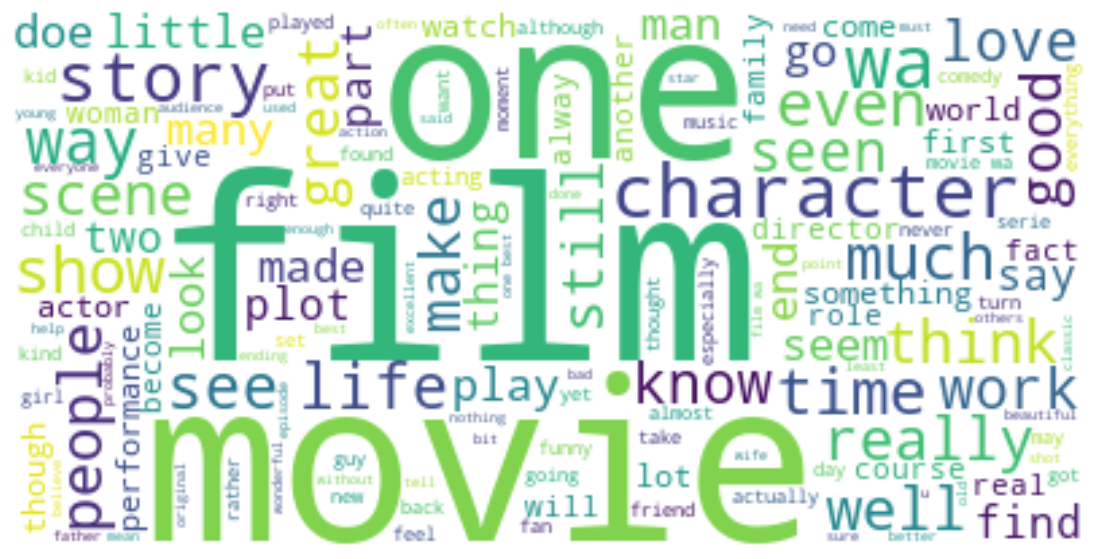

In [28]:
pos = pos_df.Text
pos_text = " ".join(review for review in pos.astype(str))
pos_wcloud=generate_wcloud(pos_text)

### Negative Movie Review Word Cloud

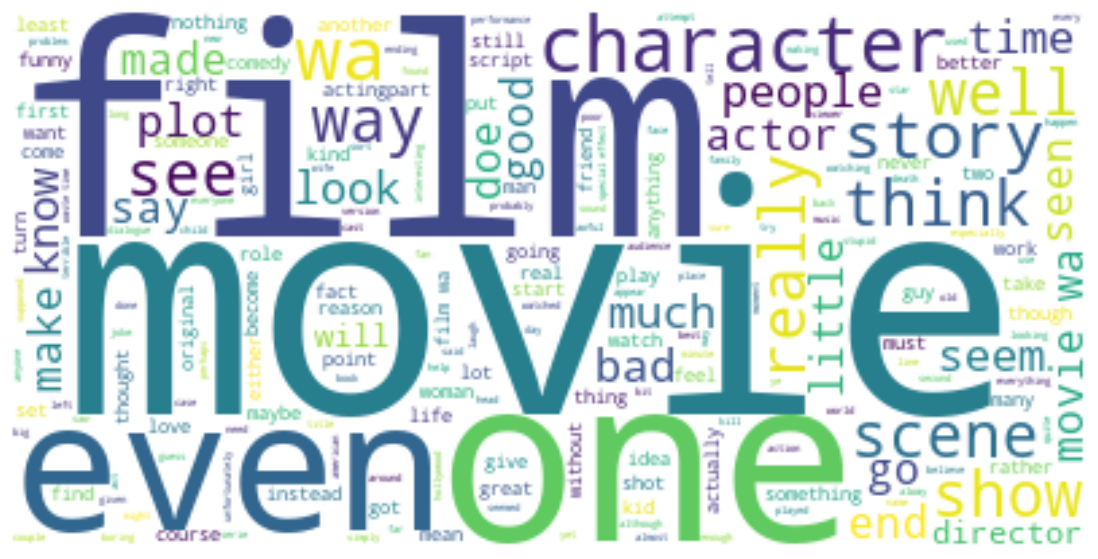

In [29]:
neg = neg_df.Text
neg_text = " ".join(review for review in neg.astype(str))
neg_wcloud=generate_wcloud(neg_text)

### Spread of positive sentiments

Text(0.5, 1.0, 'Countplot of positive sentiments')

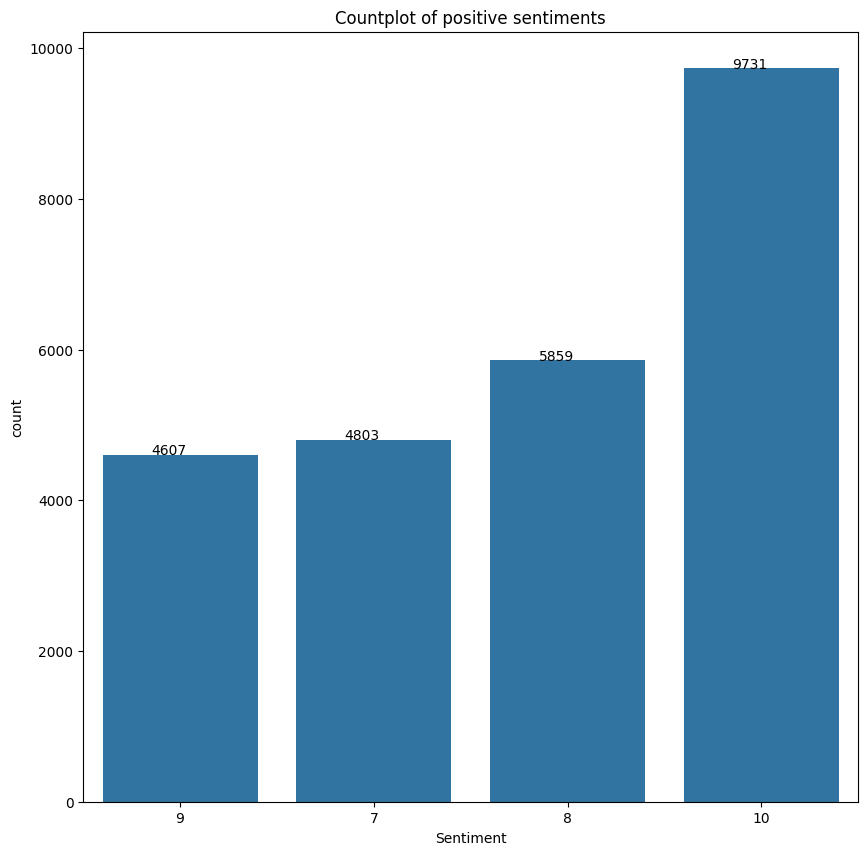

In [30]:
plt.figure(figsize=(10,10))

ax = sns.countplot(
    x="Sentiment",
    data=pos_df,
    order=pos_df['Sentiment'].value_counts(ascending=True).index
)

for p, label in zip(ax.patches, pos_df['Sentiment'].value_counts(ascending=True)):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5))

plt.title("Countplot of positive sentiments")

### Spread of negative sentiments

Text(0.5, 1.0, 'Countplot of negative sentiments')

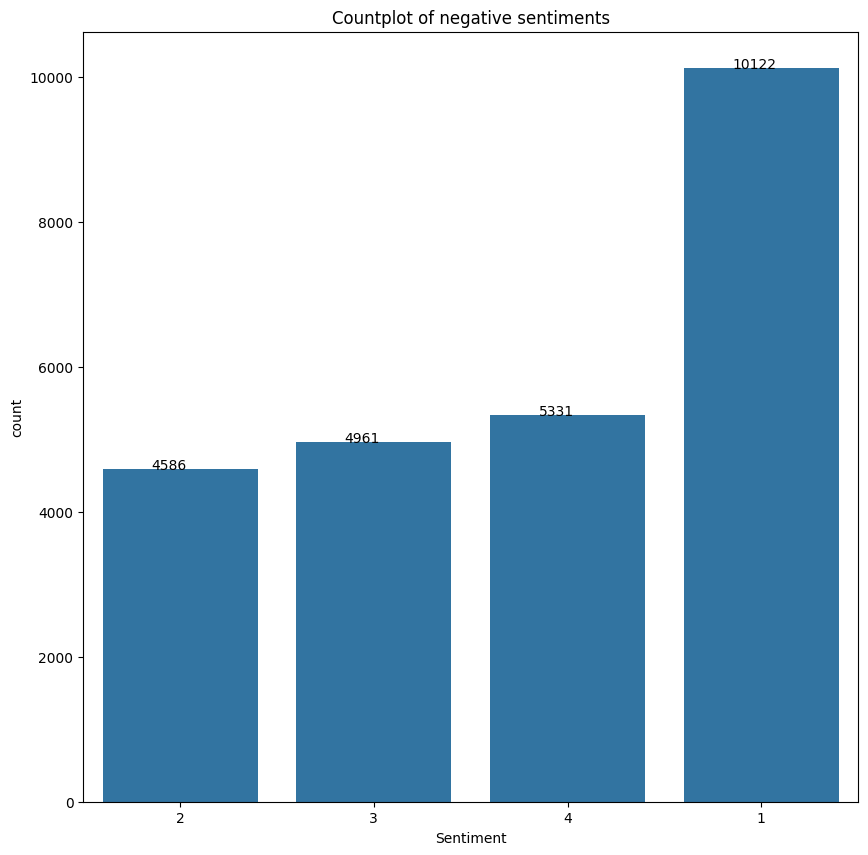

In [31]:
plt.figure(figsize=(10,10))

ax = sns.countplot(
    x="Sentiment",
    data=neg_df,
    order=neg_df['Sentiment'].value_counts(ascending=True).index
)

for p, label in zip(ax.patches, neg_df['Sentiment'].value_counts(ascending=True)):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5))

plt.title("Countplot of negative sentiments")

Comments: 
- People are more likely to give extreme ratings (1 or 10)
- Severe disproportion of Sentiments. 

### Visualise length of reviews

In [32]:
# create new column that shows length of words for each dataframe
temp_pos_df = pos_df
temp_neg_df = neg_df

# function to get length of words
def length(text):
    return len(re.findall(r'\w+', text))

temp_pos_df['word_count'] = temp_pos_df['Text'].apply(length)
temp_neg_df['word_count'] = temp_neg_df['Text'].apply(length)

Text(0.5, 1.0, 'Histogram of length of reviews in positive sentiments')

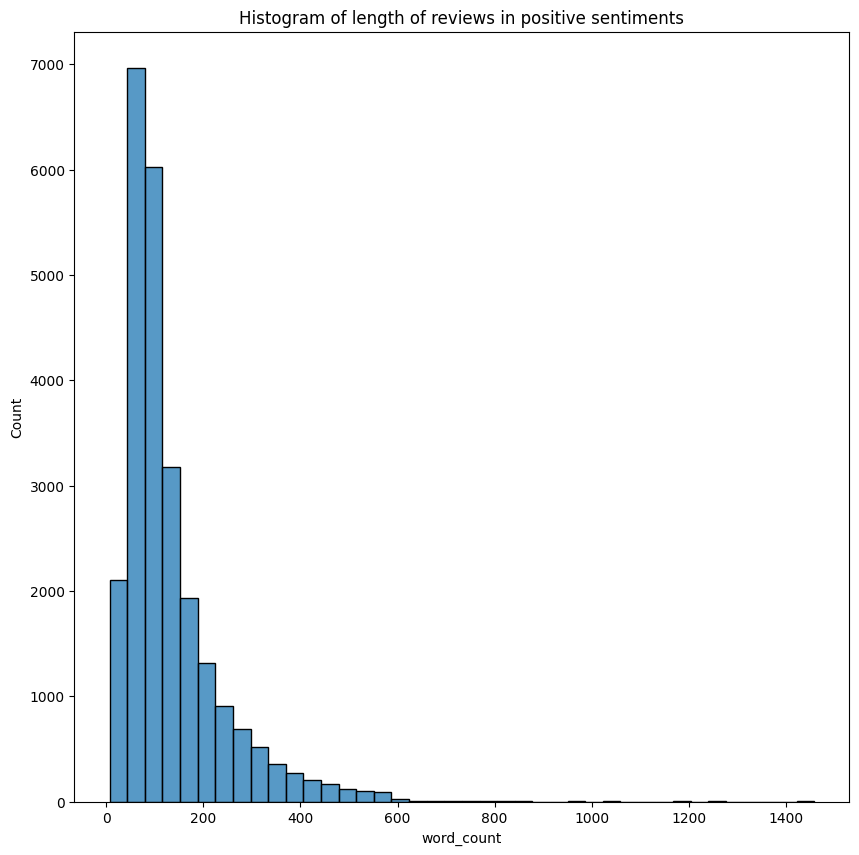

In [33]:
plt.figure(figsize=(10,10))

ax = sns.histplot(
    data=temp_pos_df,
    x='word_count',
    bins=40,
)

plt.title("Histogram of length of reviews in positive sentiments")

Text(0.5, 1.0, 'Histogram of length of reviews in negative sentiments')

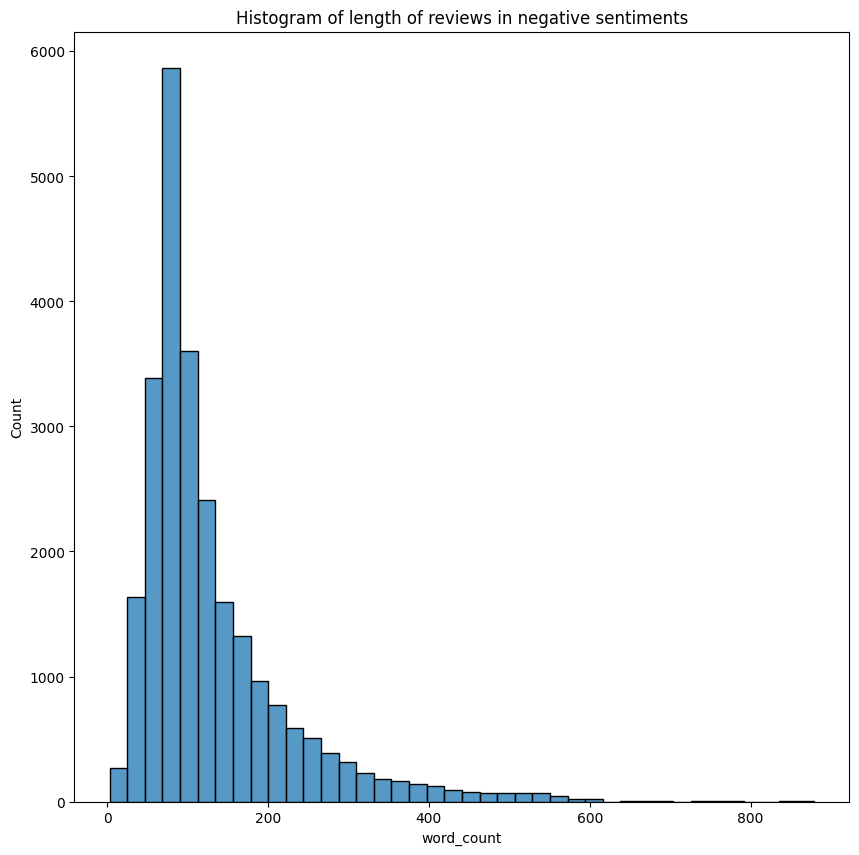

In [34]:
plt.figure(figsize=(10,10))

ax = sns.histplot(
    data=temp_neg_df,
    x='word_count',
    bins=40,
)

plt.title("Histogram of length of reviews in negative sentiments")

In [35]:
temp_pos_df['positive?'] = 'positive'
temp_neg_df['positive?'] = 'negative'

temp_combined_df = pd.concat([temp_pos_df, temp_neg_df], ignore_index=True)
temp_combined_df.head()

,Text,Sentiment,word_count,positive?
0,watched return lonesome dove wa good have seen...,9,78,positive
1,movie looked like classic cheesy 80 slasher ge...,8,306,positive
2,jay chou play orphan raised kung fu school kic...,8,232,positive
3,ooverall movie wa fairly good good action plot...,7,74,positive
4,movie is fun watch liked dave kevin klein will...,8,99,positive


Text(0.5, 1.0, 'Length of reviews in positive and negative sentiments')

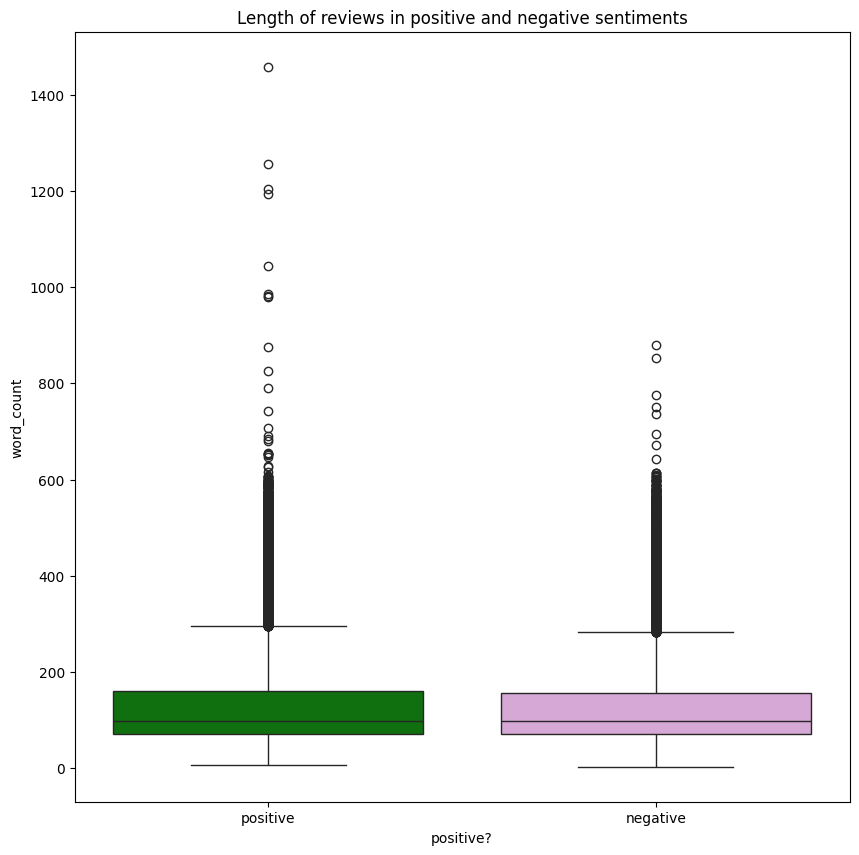

In [36]:
plt.figure(figsize=(10,10))
palette = ['g', 'plum']

ax = sns.boxplot(
    data=temp_combined_df,
    y='word_count',
    x='positive?',
    palette=palette
)
plt.title("Length of reviews in positive and negative sentiments")

In [37]:
pos_median = temp_pos_df['word_count'].median()
neg_median = temp_neg_df['word_count'].median()
print(f"Median word count of positive data: {int(pos_median)}")
print(f"Median word count of negative data: {int(neg_median)}")


Median word count of positive data: 97
Median word count of negative data: 98


In [38]:
pos_max = temp_pos_df['word_count'].max()
neg_max = temp_neg_df['word_count'].max()
print(f"Max word count of positive data: {int(pos_max)}")
print(f"Max word count of negative data: {int(neg_max)}")

Max word count of positive data: 1458
Max word count of negative data: 879


Comments: Can consider removing the outliers above a certain word count

In [39]:
# Code to remove the outliers?

### N-gram analyis on text

N-gram plot function

In [40]:
def plot_top_ngrams(text, range, top_n=10, title='Top N-grams'):
    """
    Analyze and plot the top N n-grams in a given text.
    
    Parameters:
    - text: The text to analyze, as a single string.
    - ngram_range: A tuple (min_n, max_n) specifying the range of n-grams to consider.
    - top_n: The number of top n-grams to display.
    - title: The title of the plot.
    """
    
    vectorizer = CountVectorizer(ngram_range=range)
    X = vectorizer.fit_transform([text])
    ngram_vocab = vectorizer.get_feature_names_out()
    ngram_counts = X.toarray().flatten()
    ngram_dict = dict(zip(ngram_vocab, ngram_counts))
    top_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    ngram_words, ngram_counts = zip(*top_ngrams)
    
    # Plot the top n-grams
    plt.figure(figsize=(12, 6))
    plt.barh(ngram_words, ngram_counts)
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

### Top Trigrams

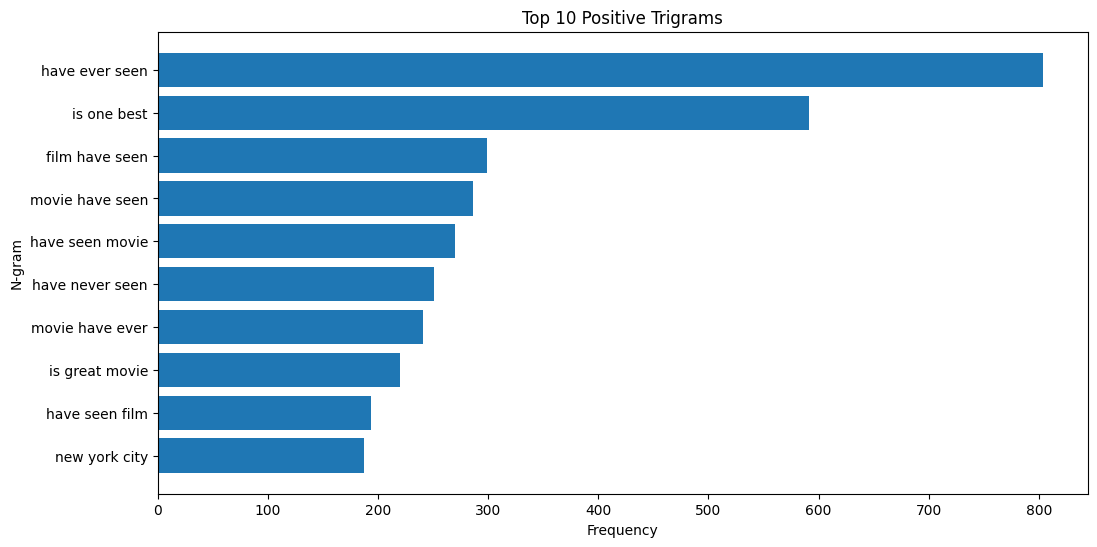

In [41]:
range = (3,3)
plot_top_ngrams(pos_text, range, top_n=10, title='Top 10 Positive Trigrams')

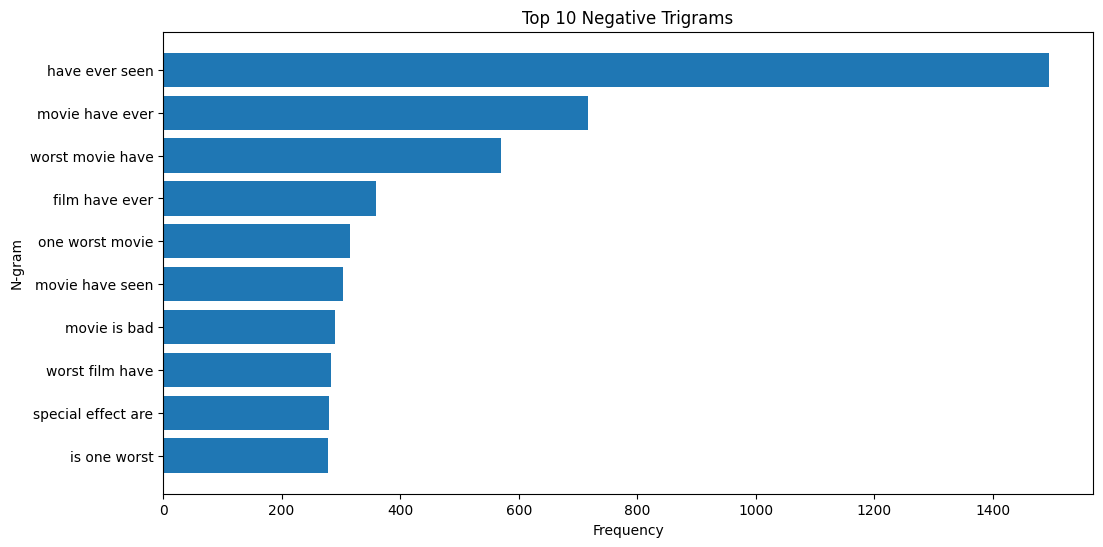

In [42]:
range = (3,3)
plot_top_ngrams(neg_text, range, top_n=10, title='Top 10 Negative Trigrams')

### Top bigrams

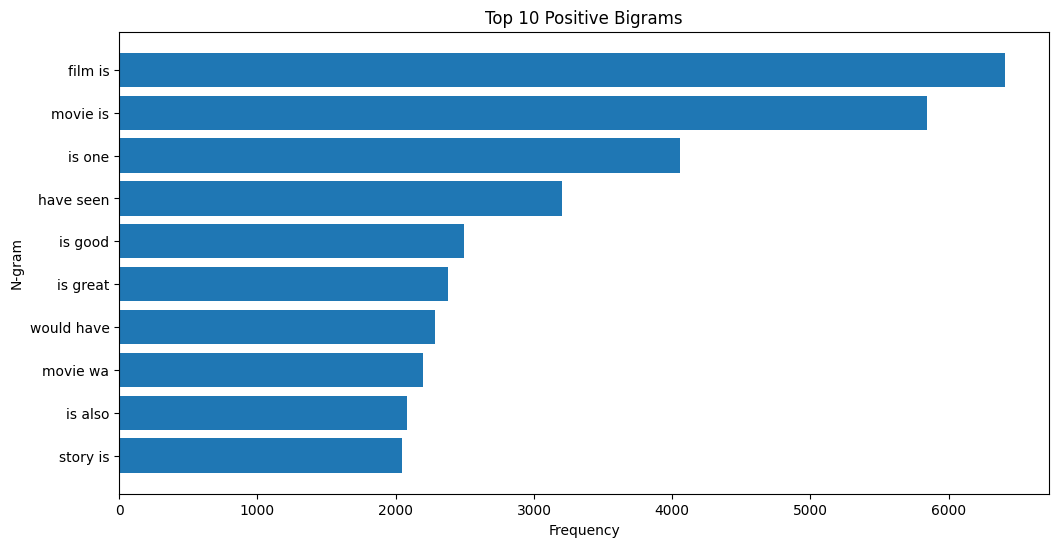

In [43]:
range = (2,2)
plot_top_ngrams(pos_text, range, top_n=10, title='Top 10 Positive Bigrams')

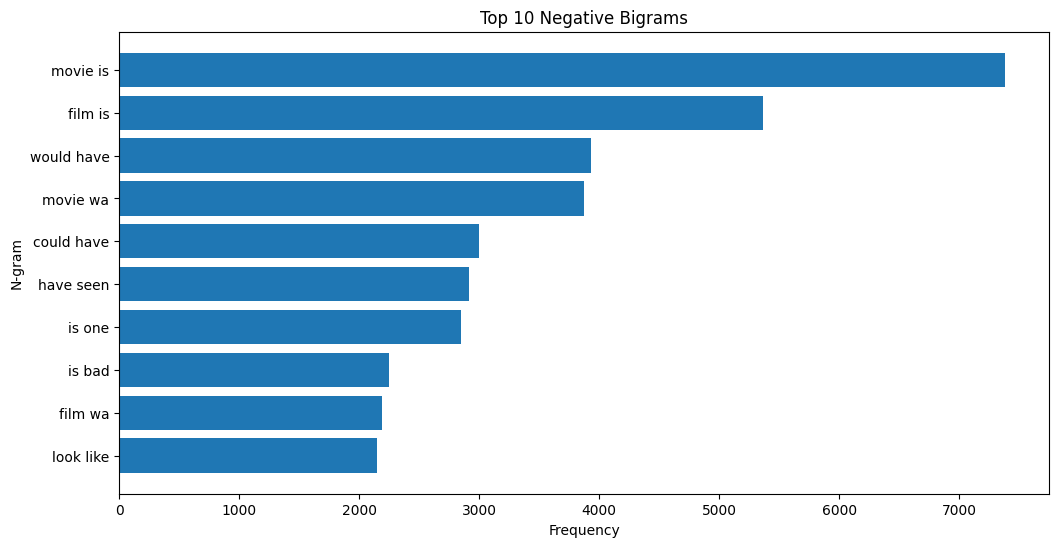

In [44]:
range = (2,2)
plot_top_ngrams(neg_text, range, top_n=10, title='Top 10 Negative Bigrams')

### Most Frequent Words

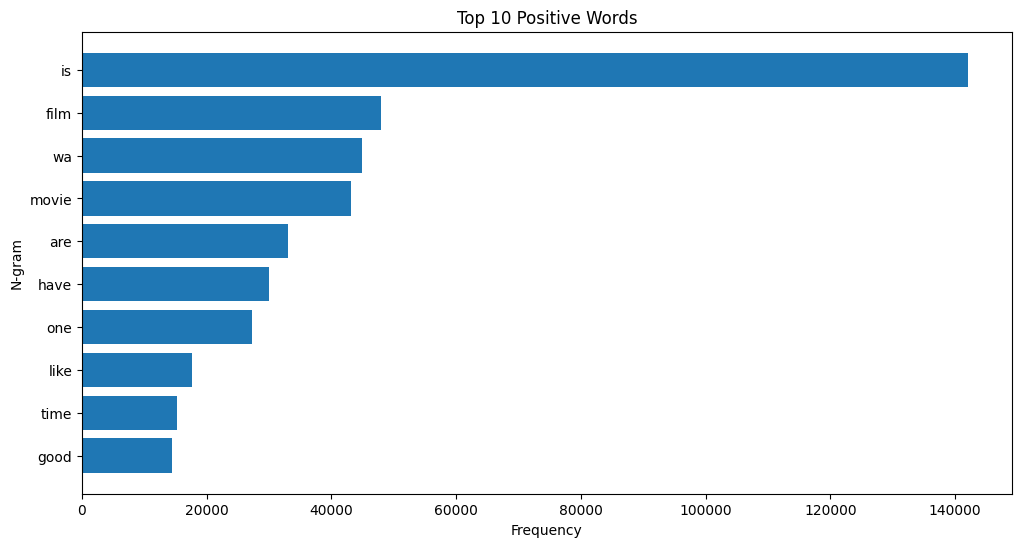

In [45]:
range = (1,1)
plot_top_ngrams(pos_text, range, top_n=10, title='Top 10 Positive Words')

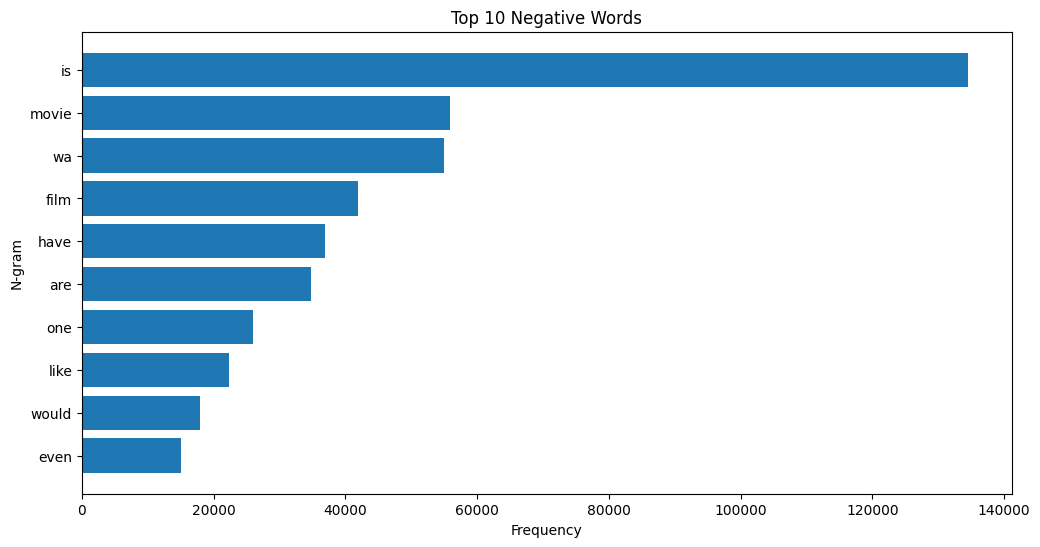

In [46]:
range = (1,1)
plot_top_ngrams(neg_text, range, top_n=10, title='Top 10 Negative Words')

## Train test split


In [50]:
# Bring all positive rating values down to range of 5-8 (to ensure continuous range of ratings)
pos_df['Sentiment'] = pos_df['Sentiment'] - 2

# Merging data into one dataset
data = pd.concat([pos_df, neg_df], ignore_index=True)

In [51]:
data.shape

(50000, 4)

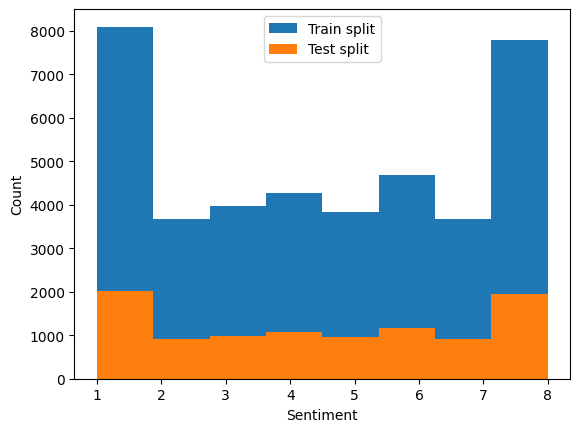

In [54]:
from sklearn.model_selection import train_test_split

X = data['Text']
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200, stratify=y)
train_split = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], ignore_index=True, axis=1)
train_split = train_split.rename(columns={0: 'Text', 1: 'Sentiment'}) 

test_split = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], ignore_index=True, axis=1)
test_split = test_split.rename(columns={0: 'Text', 1: 'Sentiment'}) 

plt.hist(train_split['Sentiment'], bins=8)
plt.hist(test_split['Sentiment'], bins=8)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(['Train split', 'Test split'])

In [60]:
train_split['Sentiment'].value_counts()

Sentiment
1    8098
8    7785
6    4687
4    4265
3    3969
5    3842
7    3685
2    3669
Name: count, dtype: int64

In [61]:
test_split['Sentiment'].value_counts()

Sentiment
1    2024
8    1946
6    1172
4    1066
3     992
5     961
7     922
2     917
Name: count, dtype: int64

## Balancing of class proportions

Random Oversampling

In [55]:
import numpy as np

In [62]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(train_split['Text']).reshape(-1, 1), np.array(train_split['Sentiment']).reshape(-1, 1))

#Get Oversampled training data
train_oversampled_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['Text', 'Sentiment'])

In [65]:
train_oversampled_df['Sentiment'].value_counts()

Sentiment
6    8098
7    8098
4    8098
8    8098
1    8098
2    8098
3    8098
5    8098
Name: count, dtype: int64

In [63]:
ros = RandomOverSampler()
test_x, test_y = ros.fit_resample(np.array(test_split['Text']).reshape(-1, 1), np.array(test_split['Sentiment']).reshape(-1, 1))

#Get Oversampled training data
test_oversampled_df = pd.DataFrame(list(zip([x[0] for x in test_x], test_y)), columns = ['Text', 'Sentiment'])

In [66]:
test_oversampled_df['Sentiment'].value_counts()

Sentiment
1    2024
4    2024
7    2024
2    2024
3    2024
6    2024
8    2024
5    2024
Name: count, dtype: int64

In [67]:
# export random oversampled dataframes as csv (don't have to run anymore)
#train_oversampled_df.to_csv('ML_train.csv')
#test_oversampled_df.to_csv('ML_test.csv')

SMOTE

We tried to use SMOTE to oversample the data using KNN. However, this was unfeasible as the array generated from SMOTE was of dimensions (25000, 112107) and required too much memory to store

```python
from sklearn.feature_extraction.text import CountVectorizer

text_pos = pos_df[['Text']]
sentiment_pos = pos_df['Sentiment']

print(f"Initial positive dataset shape {Counter(sentiment_pos)}")

vectorizer = CountVectorizer()
vectorizer.fit(text_pos.values.ravel())
text_pos = vectorizer.transform(text_pos.values.ravel())
text_pos = text_pos.toarray()

smote = SMOTE(sampling_strategy='all', random_state=42) # resulted in memory error

text_pos_res, sentiment_pos_res = smote.fit_resample(text_pos, sentiment_pos)
print(f'Resampled positive dataset shape {Counter(sentiment_pos_res)}')

```

ADASYN

Same for the ADASYN algorithm to oversample the data.

```python
text_pos = pos_df[['Text']]
sentiment_pos = pos_df['Sentiment']

print(f"Initial positive dataset shape {Counter(sentiment_pos)}")

vectorizer = CountVectorizer()
vectorizer.fit(text_pos.values.ravel())
text_pos = vectorizer.transform(text_pos.values.ravel())
text_pos = text_pos.toarray()

adasyn = ADASYN(sampling_strategy='all', random_state=42)

text_pos_res, sentiment_pos_res = adasyn.fit_resample(text_pos, sentiment_pos)
print(f'Resampled positive dataset shape {Counter(sentiment_pos_res)}')
```